In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# importing locations dataset (309.6 mb)
df_loc = pd.read_csv('instagram_locations.csv', sep='\t')

In [ ]:
# importing posts dataset (12.88 gb)
df_posts = pd.read_csv('instagram_posts.csv', sep='\t', )

In [3]:
# importing profiles dataset (698.8 mb)
df_prof = pd.read_csv('instagram_profiles.csv', sep='\t')

In [4]:
RQ2_1 = df_prof[["profile_id", "n_posts"]].copy()

In [5]:
RQ2_1.head()

,profile_id,n_posts
0,4.721050e+09,170.0
1,5.905830e+08,2878.0
2,1.074147e+09,431.0
3,1.472039e+09,NaN
4,3.531421e+09,NaN


In [6]:
RQ2_1.dropna(inplace=True)

In [6]:
RQ2_1.head()

,profile_id,n_posts
0,4.721050e+09,170.0
1,5.905830e+08,2878.0
2,1.074147e+09,431.0
5,1.450642e+08,590.0
6,2.061868e+09,753.0


In [12]:
RQ2_1_2 = RQ2_1.sort_values(by=['n_posts'], ascending=False)[:100]

In [8]:
RQ2_1_2.shape

(100, 2)

In [22]:
RQ2_1_2["n_posts"].min()

18811.0

<AxesSubplot:xlabel='profile_id'>

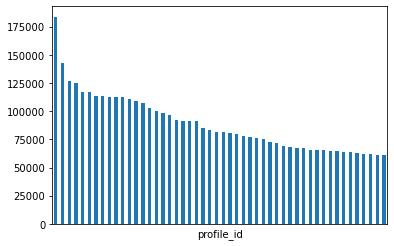

In [13]:
RQ2_1_2.plot(x="profile_id", y="n_posts", kind="bar", xticks=[], legend=False)

--- EXPLORATORY DATA ANALYSIS (EDA) ---

In [46]:
### Locations dataset ###
#print(df_loc.shape)
#print(df_loc.isna().sum())

### Posts dataset ###
#print(df_posts.shape)
#print(df_posts.isna().sum())

### Profiles dataset ###
print(df_prof.shape)
#print(df_prof.isna().sum())
print(df_prof["followers"].max())
print(df_prof["followers"].mean())

(4509586, 11)
285457645.0
4739.899180397426


In [ ]:
# RQ2_2
RQ2_2 = df_posts[["post_id", "numbr_likes"]].copy()